In [1]:
import os, gc, sys
from glob import glob
from tqdm.notebook import tqdm
import itertools
import pandas as pd
import numpy as np

import re

In [2]:
prefix = os.getcwd().split("jdi-qasp-ml")[0]
sys.path.append(os.path.join(prefix, "jdi-qasp-ml"))
model_path = os.path.join(prefix, "jdi-qasp-ml", "HTML5_model/model")
df_path = os.path.join(prefix, "jdi-qasp-ml", "data/html5_dataset/df")

ds_files = glob(f"{df_path}/html5*.pkl")

In [10]:
# test model load
import pickle
with open(f"/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/HTML5_model/model/DT_model.pkl", "rb") as file:
        model = pickle.load(file)

In [11]:
model

DecisionTreeClassifier(max_depth=20)

In [3]:
# TEST builder
from utils.dataset import HTML5_JDNDataset

dataset111 = HTML5_JDNDataset(
        datasets_list=["html5-161","html5-162"], rebalance_and_shuffle=False
    )

2022-01-12 15:45:34,186 -INFO - config.py:31 - Module utils.config was loaded
2022-01-12 15:45:34,988 -INFO - common.py:119 - Module utils.common is loaded...
2022-01-12 15:45:34,989 -INFO - hidden.py:70 - hidden module is loaded
2022-01-12 15:45:34,993 -INFO - features_builder.py:777 - feature_bilder module is loaded...
2022-01-12 15:45:35,894 -INFO - dataset.py:256 - dataset module is loaded...


100%|██████████| 2/2 [00:02<00:00,  1.29s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-162.pkl]

2022-01-12 15:45:38,477 -INFO - dataset.py:209 - self.df.shape: (1520, 33)
2022-01-12 15:45:38,478 -INFO - dataset.py:101 - Check for duplicates...
2022-01-12 15:45:38,480 -INFO - dataset.py:105 - Check for duplicates is OK
2022-01-12 15:45:38,481 -INFO - dataset.py:213 - Calculating features...
2022-01-12 15:45:38,573 -INFO - dataset_collector.py:177 - X: (1520, 79)
2022-01-12 15:45:38,574 -INFO - dataset.py:217 - Features have calculated succesfully!


In [4]:
dataset111.df

,attributes,displayed,element_id,height,html,onmouseenter,onmouseover,parent_id,style,tag_name,...,children_tags,num_followers,upper_sibling,lower_sibling,siblings,attributes_list,type,childs,childs_types,label
333,"{'class': '90ae9aaf', 'data-label': 'label', '...",True,0000239658929225655951296676,48.000000,"<label for=""d07450d3"" label=""label"" data-label...",None,None,8718247322929225650562200629,"[accent-color, align-content, align-items, ali...",LABEL,...,,0,9363131971929225658980006253,1707099321929225654389190393,"(9363131971929225658980006253, 170709932192922...",class data-label for id label name style,n/a,None,[None],9
52,{'value': '649'},False,0009779310929225645925542064,0.000000,"<option value=""649""></option>",None,None,5182772019929225645788495327,"[accent-color, align-content, align-items, ali...",OPTION,...,,0,1004139786929225643874232759,8058766544929225640176585155,"(1004139786929225643874232759, 805876654492922...",value,n/a,None,[None],0
30,None,True,0015811730929225649897678679,34.000000,"<div>\n <label for=""de22725...",None,None,7083480194929225636179133956,"[accent-color, align-content, align-items, ali...",DIV,...,label input datalist,3,5529791680929225643540241405,0212491801929225643425787405,"(5529791680929225643540241405, 021249180192922...",,n/a,"[0647559080929225642460477142, 730661286892922...","[None, range, None]",0
580,"{'class': '5622782b', 'data-label': 'n/a', 'id...",False,0032239934929225652205052061,0.000000,"<option data-label=""n/a"" class=""5622782b"" id=""...",None,None,3346353949929225655163584111,"[accent-color, align-content, align-items, ali...",OPTION,...,,0,None,4125798126929225654465516972,"(None, 4125798126929225654465516972)",class data-label id name style,n/a,None,[None],0
54,{'value': '681'},False,0055509561929225648121853815,0.000000,"<option value=""681""></option>",None,None,5182772019929225645788495327,"[accent-color, align-content, align-items, ali...",OPTION,...,,0,8058766544929225640176585155,1842360355929225644944265626,"(8058766544929225640176585155, 184236035592922...",value,n/a,None,[None],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,None,True,9957293902941036248470400520,44.609375,"<tr><td style=""border-style:ridge; border-widt...",None,None,5465469888941036240414018076,"[accent-color, align-content, align-items, ali...",TR,...,td,3,5531135976941036248132218482,0669940843941036247118729907,"(5531135976941036248132218482, 066994084394103...",,n/a,[7684913736941036242200677563],[None],0
490,"{'class': '1d39e48a', 'data-label': 'n/a', 'id...",True,9981356470941036250287003534,34.593750,"<option style=""color:#00165e; font-size:28px;""...",None,None,0497803971941036256326424953,"[accent-color, align-content, align-items, ali...",OPTION,...,,0,6596962241941036259809027734,2349785291941036252038347792,"(6596962241941036259809027734, 234978529194103...",class data-label id name style,n/a,None,[None],0
229,"{'class': 'fd345cc6', 'data-label': 'label', '...",True,9988681732941036249971063008,21.000000,"<label name=""6c8632ff"" id=""480bbc91"" class=""fd...",None,None,8711843737941036241460127857,"[accent-color, align-content, align-items, ali...",LABEL,...,,0,5925023570941036248927645519,6786301943941036247968396660,"(5925023570941036248927645519, 678630194394103...",class data-label for id label name style,n/a,None,[None],9
86,"{'checked': '', 'class': 'c47580dc', 'data-lab...",True,9993588001941036249388286963,13.000000,"<input name=""6e0324cd"" style=""color:#017c38; f...",None,None,2647330964941036243339555580,"[accent-color, align-content, align-items, ali...",INPUT,...,,0,1268180992941036248994640089,9079590923941036242211015376,"(1268180992941036248994640089, 907959092394103...",checked class data-label id name style type,checkbox,None,[None],2


In [5]:

# df = pd.DataFrame()
# for file in tqdm(ds_files[:200]):
#     df_1 = pd.read_pickle(file)
#     df_1['label'] = df_1.attributes.apply(lambda x: None if (None if x is None else x.get("data-label")) is None else x.get("data-label")).fillna("n/a")
#     df_1['attributes_list'] = df_1.attributes.apply(lambda x: "" if x is None else " ".join(list(x.keys())))
#     df_1["type"] = df_1.attributes.apply(lambda x: None if (None if x is None else x.get("type")) is None else x.get("type")).fillna("n/a")
#     par_childs = {par:list(df_1[df_1.parent_id==par].element_id.unique()) for par in df_1.parent_id.unique()}
#     df_1['childs'] = df_1['element_id'].apply(lambda x: par_childs.get(x))
#     df_1["childs_types"] = df_1['childs'].apply(lambda l : [None] if l is None else [df_1[df_1.element_id==i].type.iloc[0] if df_1[df_1.element_id==i].type.iloc[0] != "n/a" else None for i in l])
#     df_1["is_checkbox_in_childs"] = df_1["childs_types"].apply(lambda x: 1 if "checkbox" in x else 0)
#     df_1["is_radio_in_childs"] = df_1["childs_types"].apply(lambda x: 1 if "radio" in x else 0)
#     df = pd.concat([df, df_1]).reset_index(drop=True)

X = pd.DataFrame()
y = np.array([])
for file in tqdm(ds_files[:10]):
    
    dataset111 = HTML5_JDNDataset(
        datasets_list=[file.split("/")[-1][:-4]], rebalance_and_shuffle=False
    )
    X = pd.concat([dataset111.X, X]).reset_index(drop=True)
    y = np.concatenate((dataset111.y, y))

# # df.to_parquet(f"{prefix}jdi-qasp-ml/data/html5_dataset/html5_full_dataset.parquet")

  0%|          | 0/10 [00:00<?, ?it/s]








100%|██████████| 1/1 [00:01<00:00,  1.16s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-161.pkl]

2022-01-11 17:32:11,027 -INFO - dataset.py:208 - self.df.shape: (822, 29)
2022-01-11 17:32:11,028 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:11,030 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:11,828 -INFO - dataset_collector.py:177 - X: (822, 79)








100%|██████████| 1/1 [00:01<00:00,  1.04s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-175.pkl]

2022-01-11 17:32:12,889 -INFO - dataset.py:208 - self.df.shape: (635, 29)
2022-01-11 17:32:12,890 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:12,893 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:13,571 -INFO - dataset_collector.py:177 - X: (635, 79)








100%|██████████| 1/1 [00:01<00:00,  1.13s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-149.pkl]

2022-01-11 17:32:14,726 -INFO - dataset.py:208 - self.df.shape: (849, 29)
2022-01-11 17:32:14,727 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:14,729 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:15,419 -INFO - dataset_collector.py:177 - X: (849, 79)








100%|██████████| 1/1 [00:01<00:00,  1.06s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-99.pkl]

2022-01-11 17:32:16,499 -INFO - dataset.py:208 - self.df.shape: (851, 29)
2022-01-11 17:32:16,500 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:16,502 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:17,146 -INFO - dataset_collector.py:177 - X: (851, 79)









100%|██████████| 1/1 [00:01<00:00,  1.11s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-66.pkl]

2022-01-11 17:32:18,269 -INFO - dataset.py:208 - self.df.shape: (906, 29)
2022-01-11 17:32:18,270 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:18,273 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:18,999 -INFO - dataset_collector.py:177 - X: (906, 79)








100%|██████████| 1/1 [00:01<00:00,  1.02s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-72.pkl]

2022-01-11 17:32:20,042 -INFO - dataset.py:208 - self.df.shape: (780, 29)
2022-01-11 17:32:20,043 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:20,045 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:20,771 -INFO - dataset_collector.py:177 - X: (780, 79)








100%|██████████| 1/1 [00:00<00:00,  1.04it/s, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-217.pkl]

2022-01-11 17:32:21,755 -INFO - dataset.py:208 - self.df.shape: (752, 29)


2022-01-11 17:32:21,757 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:21,759 -INFO - dataset.py:105 - Check for duplicates is OK
2022-01-11 17:32:22,435 -INFO - dataset_collector.py:177 - X: (752, 79)







100%|██████████| 1/1 [00:00<00:00,  1.30it/s, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-203.pkl]

2022-01-11 17:32:23,224 -INFO - dataset.py:208 - self.df.shape: (547, 29)
2022-01-11 17:32:23,225 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:23,227 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:23,805 -INFO - dataset_collector.py:177 - X: (547, 79)








100%|██████████| 1/1 [00:01<00:00,  1.07s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-202.pkl]

2022-01-11 17:32:24,896 -INFO - dataset.py:208 - self.df.shape: (738, 29)
2022-01-11 17:32:24,897 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:24,899 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:25,584 -INFO - dataset_collector.py:177 - X: (738, 79)








100%|██████████| 1/1 [00:01<00:00,  1.13s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html5-216.pkl]

2022-01-11 17:32:26,735 -INFO - dataset.py:208 - self.df.shape: (872, 29)
2022-01-11 17:32:26,736 -INFO - dataset.py:101 - Check for duplicates...
2022-01-11 17:32:26,738 -INFO - dataset.py:105 - Check for duplicates is OK


2022-01-11 17:32:27,522 -INFO - dataset_collector.py:177 - X: (872, 79)


In [6]:
z = set(['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE',
       'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_DATALIST',
       'tag_OPTION', 'tag_TEXTAREA', 'tag_FORM', 'tag_A', 'tag_H2',
       'tag_SELECT', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD',
       'tag_PROGRESS', 'tag_P', 'tag_H5', 'tag_BR', 'tag_H6', 'tag_H1',
       'tag_H3', 'tag_BUTTON', 'tag_H4', 'attr_accept', 'attr_value',
       'attr_wrap', 'attr_download', 'attr_ping', 'attr_referrerpolicy',
       'attr_target', 'attr_capture', 'attr_pattern', 'attr_href',
       'attr_autocomplete', 'attr_required', 'attr_max', 'attr_readonly',
       'attr_multiple', 'attr_maxlength', 'attr_rel', 'attr_charset',
       'attr_step', 'attr_for', 'attr_checked', 'attr_rows',
       'attr_formenctype', 'attr_list', 'attr_indeterminate',
       'attr_spellcheck', 'attr_placeholder', 'attr_minlength', 'attr_cols',
       'attr_min', 'attr_formaction', 'attr_size', 'attr_lang', 'type_number',
       'type_file', 'type_text', 'type_color', 'type_week', 'type_reset',
       'type_radio', 'type_submit', 'type_month', 'type_time', 'type_checkbox',
       'type_range', 'type_button', 'type_datetime-local', 'type_date',
       'is_checkbox_in_childs', 'is_radio_in_childs'])

In [8]:
X

,tag_HTML,tag_HEAD,tag_META,tag_TITLE,tag_STYLE,tag_BODY,tag_DIV,tag_LABEL,tag_INPUT,tag_DATALIST,...,type_file,type_range,type_radio,type_month,type_checkbox,type_reset,type_number,type_week,is_checkbox_in_childs,is_radio_in_childs
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7748,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7749,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7750,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
# dataset = df[["element_id", "tag_name", "attributes_list", "type", "is_checkbox_in_childs", "is_radio_in_childs", "label"]].copy()

In [11]:
# dataset.head()

In [12]:
# df.label.unique()

In [13]:
# dataset.type.unique()

In [14]:
# buf_types = set([i for i in dataset.type.unique() if (not "/" in i or i == "n/a")])
# buf_types

In [15]:
# buf = re.sub(" +", " ", " ".join(dataset.attributes_list.to_list()))
# attr_columns = list(set([i for i in set(buf.split(" ")) if "font-size" not in i]) - set(["data-label", "label", "id", "name", "type", "class", "style", "disabled"]))
# tag_columns = list(dataset.tag_name.unique())
# type_columns = list(buf_types-set(["n/a"]))
# print(attr_columns)
# print(tag_columns)
# print(type_columns)

In [16]:
# dataset

In [17]:
# # pd.options.mode.chained_assignment = None
# for col in tqdm(attr_columns):
#     dataset["attr_"+col] = dataset.loc[:, "attributes_list"].apply(lambda x: 1 if col in x else 0).values

# for col in tqdm(tag_columns):
#     dataset["tag_"+col] = dataset.loc[:, "tag_name"].apply(lambda x: 1 if col == x else 0).values

# for col in tqdm(type_columns):
#     dataset["type_"+col] = dataset.loc[:, "type"].apply(lambda x: 1 if col == x else 0).values

# attr_columns = ["attr_"+col for col in attr_columns]

# tag_columns = ["tag_"+col for col in tag_columns]

# type_columns = ["type_"+col for col in type_columns]


In [18]:
# print(attr_columns)
# print(tag_columns)
# print(type_columns)

In [19]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# dataset["label"] = le.fit_transform(dataset["label"])

In [20]:
# DF = dataset[tag_columns + attr_columns 
#                 + type_columns 
#                 + ["is_checkbox_in_childs", "is_radio_in_childs", "label"]]

In [21]:
# pd.DataFrame({"classes":le.classes_, "codes": le.transform(le.classes_)})

In [22]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy={i:30000 for i in le.transform(le.classes_) if i != 12})

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_over, y_over = ros.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

(6201, 79)
(1551, 79)


In [26]:
X_train.columns

Index(['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE',
       'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_DATALIST',
       'tag_OPTION', 'tag_TEXTAREA', 'tag_FORM', 'tag_A', 'tag_H2',
       'tag_SELECT', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD',
       'tag_PROGRESS', 'tag_P', 'tag_H5', 'tag_BR', 'tag_H6', 'tag_H1',
       'tag_H3', 'tag_BUTTON', 'tag_H4', 'attr_placeholder', 'attr_minlength',
       'attr_download', 'attr_ping', 'attr_rows', 'attr_spellcheck',
       'attr_href', 'attr_maxlength', 'attr_size', 'attr_pattern',
       'attr_accept', 'attr_rel', 'attr_formaction', 'attr_step',
       'attr_target', 'attr_checked', 'attr_autocomplete', 'attr_wrap',
       'attr_min', 'attr_indeterminate', 'attr_for', 'attr_list',
       'attr_charset', 'attr_max', 'attr_capture', 'attr_referrerpolicy',
       'attr_formenctype', 'attr_readonly', 'attr_multiple', 'attr_lang',
       'attr_required', 'attr_value', 'attr_cols', 'type_button',
       'type_dateti

In [28]:
parameters = {'max_depth':range(20,25), 'criterion': ["gini", "entropy"], 'min_samples_split': range(2,5), 'min_samples_leaf': range(1,2)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_

In [29]:
clf.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
print(classification_report(y_train, tree_model.predict(X_train)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3138
         1.0       1.00      1.00      1.00        55
         2.0       1.00      1.00      1.00       447
         3.0       1.00      1.00      1.00        62
         4.0       1.00      1.00      1.00        61
         5.0       1.00      1.00      1.00        72
         6.0       1.00      1.00      1.00        57
         7.0       1.00      1.00      1.00        51
         8.0       1.00      1.00      1.00        58
         9.0       1.00      1.00      1.00      1131
        10.0       1.00      1.00      1.00        69
        11.0       1.00      1.00      1.00        48
        12.0       1.00      1.00      1.00        59
        13.0       1.00      1.00      1.00        58
        14.0       1.00      1.00      1.00        52
        15.0       1.00      1.00      1.00       322
        16.0       1.00      1.00      1.00        59
        17.0       1.00    

In [33]:
y_pred = tree_model.predict(X_test)

In [34]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       783
         1.0       1.00      0.79      0.88        14
         2.0       1.00      1.00      1.00       116
         3.0       1.00      1.00      1.00        16
         4.0       1.00      1.00      1.00        14
         5.0       1.00      1.00      1.00        15
         6.0       0.80      1.00      0.89        12
         7.0       1.00      1.00      1.00        22
         8.0       1.00      1.00      1.00        12
         9.0       1.00      1.00      1.00       265
        10.0       1.00      1.00      1.00        16
        11.0       1.00      1.00      1.00        12
        12.0       1.00      1.00      1.00        17
        13.0       1.00      1.00      1.00        20
        14.0       1.00      1.00      1.00        13
        15.0       1.00      1.00      1.00        97
        16.0       1.00      1.00      1.00        14
        17.0       1.00    

In [35]:
# print((y_pred[y_test != 7]))
# print((y_test[y_test != 7]))

In [37]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[y_test != 0], y_pred[y_test != 0])

0.99609375

In [40]:
with open("/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/classes.txt", "r") as f:
        lines = f.readlines()
        encoder_dict = {line.strip(): i for i, line in enumerate(lines)}
        decoder_dict = {v: k for k, v in encoder_dict.items()}

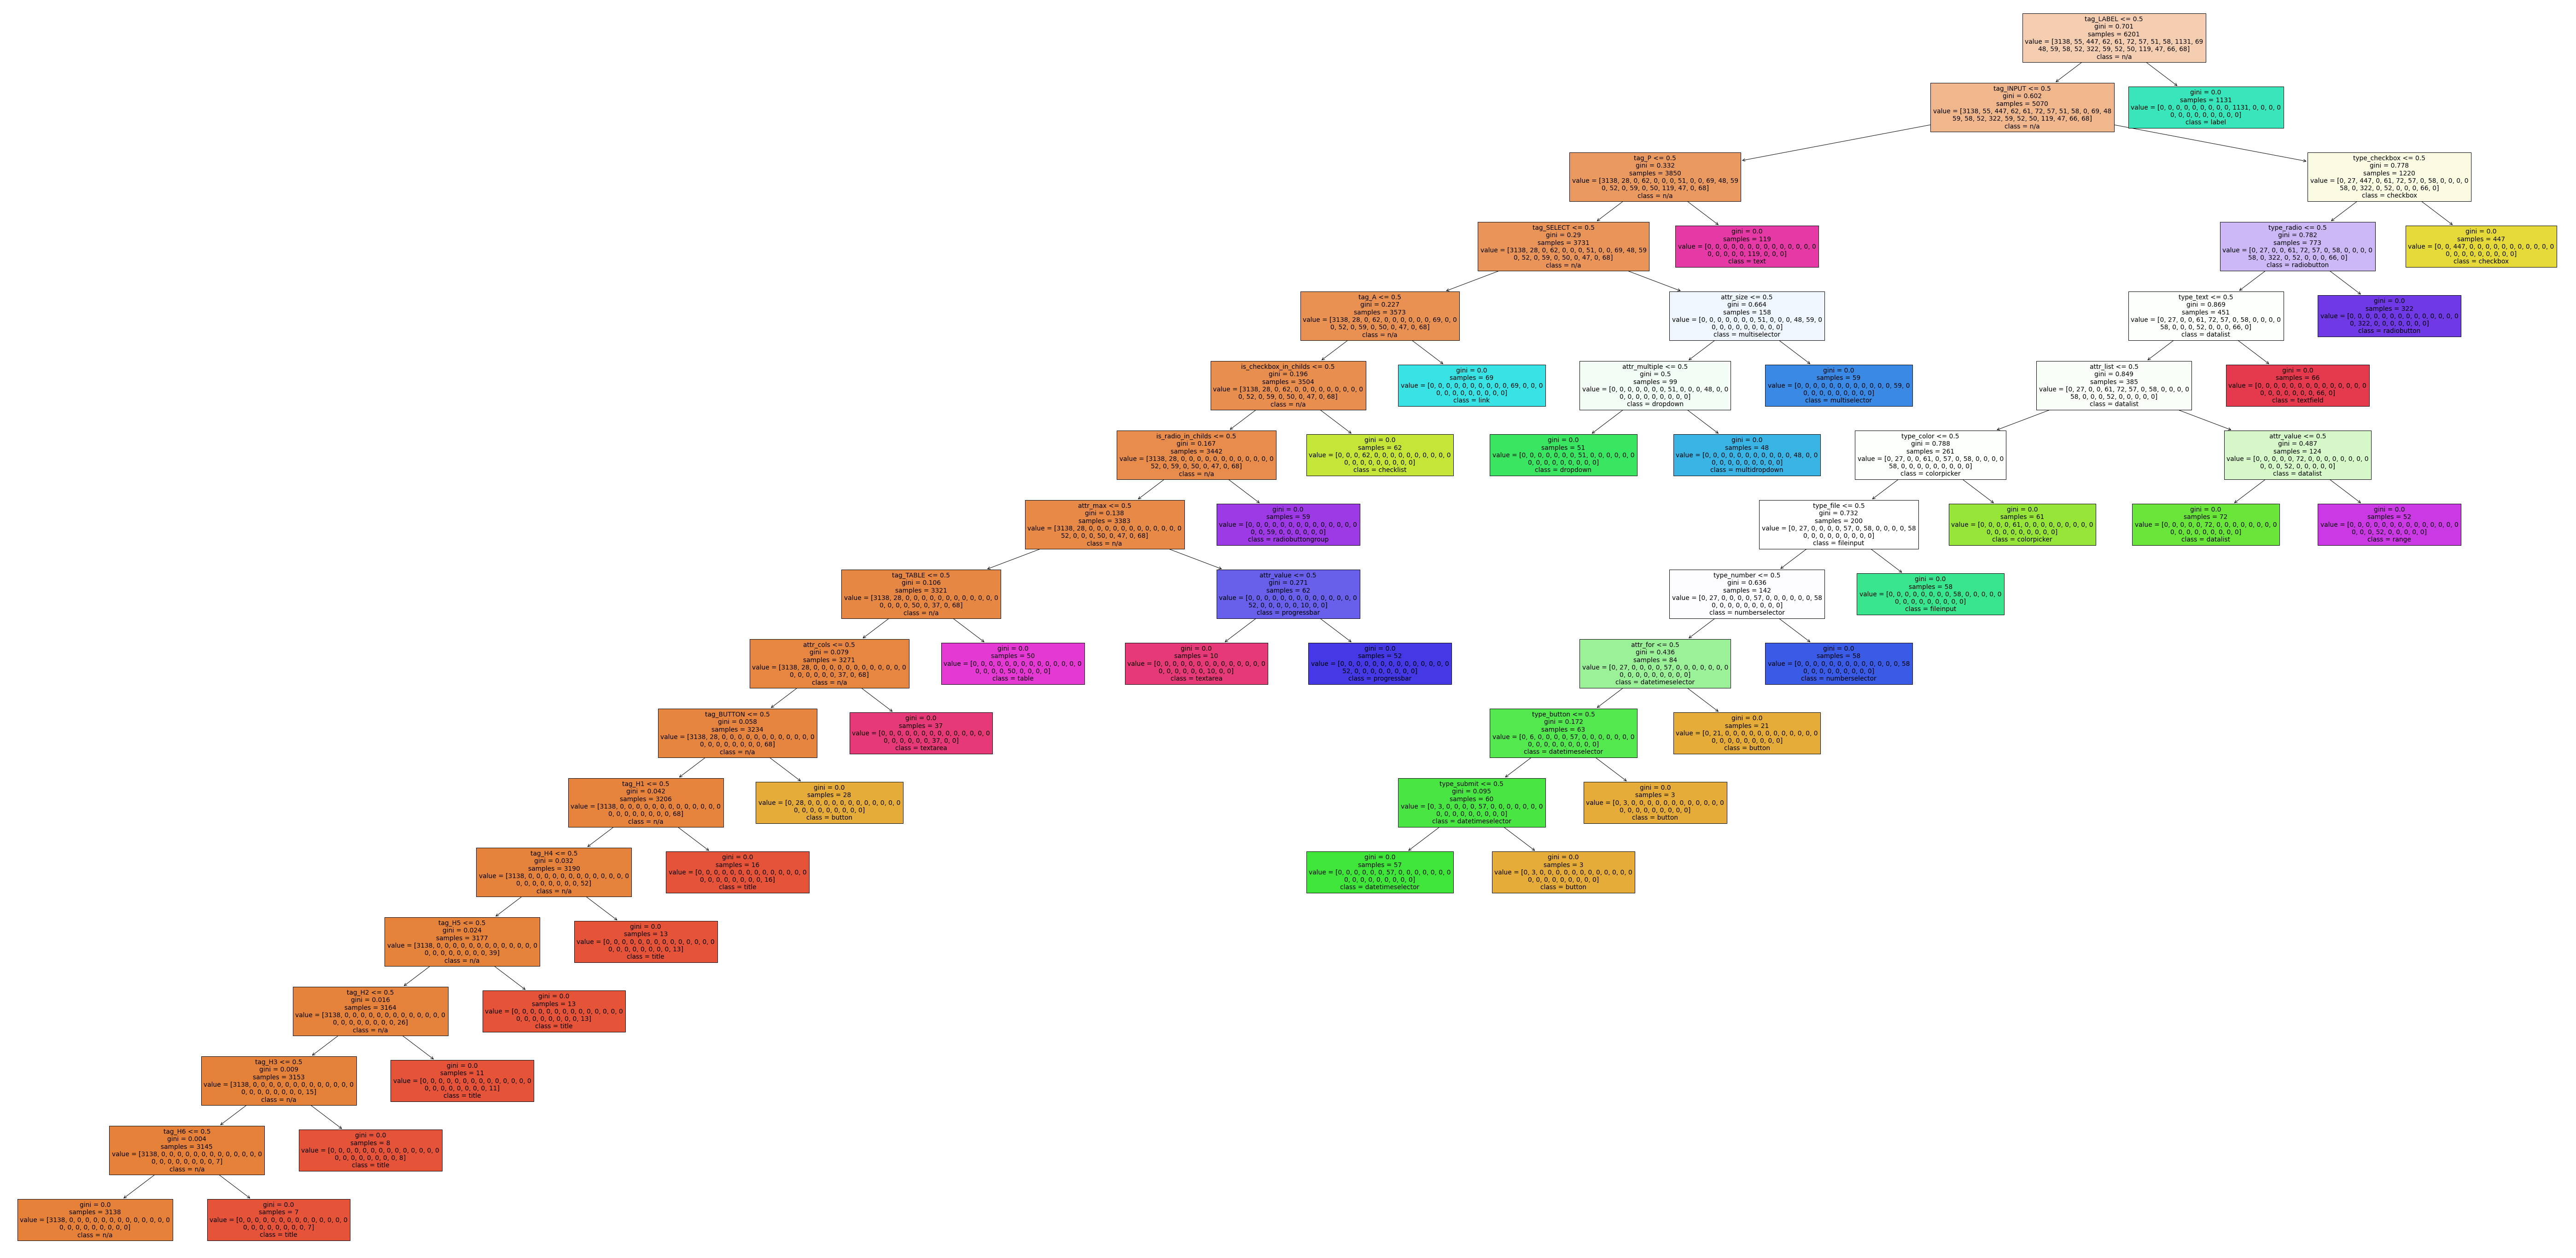

In [52]:
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(100,50))
_ = tree.plot_tree(tree_model, 
                   feature_names=X_train.columns,  
                   class_names=list(encoder_dict.keys()),
                   filled=True)
plt.savefig('tree.jpeg',format='jpeg',bbox_inches = "tight")

<Figure size 432x288 with 0 Axes>